In [13]:
!pip install matplotlib

import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 508.1 kB/s eta 0:00:00 kB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 1.7 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.0/274.0 kB 698.1 kB/s eta 0:00:00 kB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 662.5 kB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 kB 1.2 MB/s eta 0:00:003.5 MB/s eta 0:00:01


Matplotlib is building the font cache; this may take a moment.


In [14]:
def f(x):
    return 3*x**2 - 4*x + 5

In [15]:
f(3.0)

20.0

In [18]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

In [22]:
h = 0.000001
x = 2/3
# f(x + h)
(f(x + h) - f(x))/h

2.999378523327323e-06

In [24]:
a = 2.0
b = -3.0
c = 10
d = a*b + c
print(d)

4.0


In [28]:
h = 0.0001
#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [89]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __sub__(self, other):
        out = Value(self.data - other.data, (self, other), '-')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

    def __truediv__(self, other):
        out = Value(self.data / other.data, (self, other), '/')
        return out


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'

f = Value(-2.0, label='f')
L = d * f; L.label= 'L'
d

Value(data=4.0)

In [50]:
!pip install graphviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 1.3 MB/s eta 0:00:00


In [93]:
from graphviz import Digraph

def trace(root):
    # Builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = Left to Right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # For any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # If this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # Connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

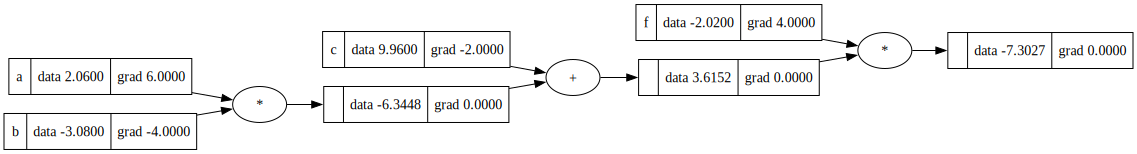

In [126]:
draw_dot(L)

In [114]:
a.grad = (-2.0 * -3.0)
b.grad = (-2.0 * 2.0)

In [ ]:
dd / dc = 1.0
dd / de = 1.0

d = c + e

# WE WANT
dL / dc = (dL / dd) * (dd / dc)

dL / de = -2 * 1

# WE KNOW
dL / dd = -2
dd / dc = 1

In [ ]:
L = d * f

dL/dd =? f

(f(x + h) - f(x))/h # Derivative formula

((d + h)*f - d*f)/h

(d*f + h*f - d*f) / h

(h*f) / h

f

In [125]:
# dL / de = -2.0

# dL / da = -2.0 * (de / da)

# e = a * b

# a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.data

e = a*b
d = e + c
L = d * f

print(L.data)

-7.302704000000001


In [122]:
def lol():
    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label= 'L'
    L1 = L.data


    a = Value(2.0, label='a')
    a.data += h
    b = Value(-3.0, label='b')
    # b.data += h
    c = Value(10.0, label='c')
    # c.data += h
    e = a*b; e.label = 'e'
    # e.data += h
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label= 'L'
    L2 = L.data

    print((L2 - L1)/h)

lol()    

6.000000000000227
